Wiener Process with drift $\mu$ and variance $\sigma^2$
===
This directory demonstrates the post-processing visualization of 100 
plain text data files. Each file has four columns: the first column 
is time and the remaining three are one-dimensional Brownian walks 
with the same mean $\mu$ and variance $\sigma^2$. 
$$\Large X_t = \mu t + \sigma W_t, \qquad X_0=0$$

<p style="align:center;">
<img src="assets/Brownian_motion_large.gif" style="display: block;  margin-left: auto;  margin-right: auto;  width: 30%;">
</p>
Below are the first ten lines of one of the data files.

In [3]:
!head dat/mu0_sigma10_wiener.txt

+0.0000000e+00 +1.6121901e-02 -2.1556124e-02 -4.2334954e-03
+1.0000000e-03 -3.0940717e-02 -3.9804579e-02 +5.8573106e-02
+2.0000000e-03 -2.0012240e-02 -1.2321402e-02 +2.4045456e-02
+3.0000000e-03 +2.4907717e-02 -6.7733886e-03 -4.0442243e-03
+4.0000000e-03 -8.5340498e-03 -1.7385692e-02 +9.6295301e-03
+5.0000000e-03 -4.0650831e-03 -3.4583822e-02 +3.1814011e-02
+6.0000000e-03 +1.8266772e-02 -1.1361694e-01 -3.2969411e-02
+7.0000000e-03 +3.0136372e-02 -6.1630401e-02 -3.3209350e-02
+8.0000000e-03 +3.7707978e-02 -2.7269198e-02 -5.2485328e-02
+9.0000000e-03 +6.9623241e-03 -2.4135298e-02 +9.8349939e-03


We could have also used Python to do this, rather than the shell:

In [5]:
import pandas as pd
df = pd.read_csv(
  'dat/mu0_sigma10_wiener.txt',
  delim_whitespace=True,
  names=[
    'time',    # the first column is time
    'sample0', # the next three are random samples
    'sample1',
    'sample2'
  ]
)
df.head(10)

,time,sample0,sample1,sample2
0,0.000,0.016122,-0.021556,-0.004233
1,0.001,-0.030941,-0.039805,0.058573
2,0.002,-0.020012,-0.012321,0.024045
3,0.003,0.024908,-0.006773,-0.004044
4,0.004,-0.008534,-0.017386,0.009630
5,0.005,-0.004065,-0.034584,0.031814
6,0.006,0.018267,-0.113617,-0.032969
7,0.007,0.030136,-0.061630,-0.033209
8,0.008,0.037708,-0.027269,-0.052485
9,0.009,0.006962,-0.024135,0.009835


With the data loaded into a Pandas DataFrame object, we gain powerful tools for post-processing, like summary statistics and plotting.

In [13]:
df.describe()

,time,sample0,sample1,sample2
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,0.500000,-0.617580,-0.575953,0.730717
std,0.289108,0.332713,0.337517,0.455193
min,0.000000,-1.193917,-1.186552,-0.372083
25%,0.250000,-0.844595,-0.870286,0.421743
50%,0.500000,-0.691347,-0.580127,0.757623
75%,0.750000,-0.544848,-0.270580,1.076842
max,1.000000,0.329773,0.067140,1.549698


(0.0, 1.0)

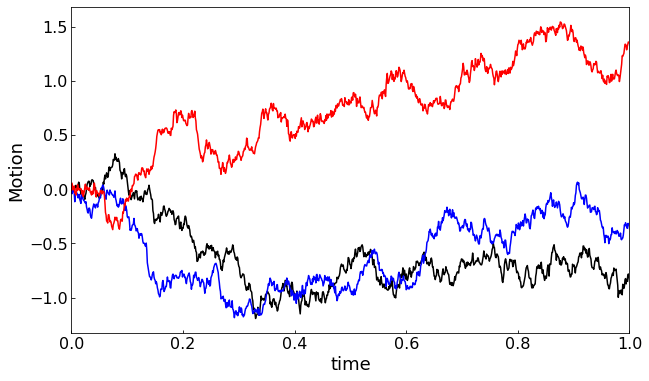

In [14]:
import pylab as plt
plt.figure(figsize=(10,6))
plt.plot(df.time,df.sample0,'k-',label='sample0')
plt.plot(df.time,df.sample1,'b-',label='sample1')
plt.plot(df.time,df.sample2,'r-',label='sample2')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction='in',which='both')
plt.xlabel('time',fontsize=18)
plt.ylabel('Motion',fontsize=18)
plt.xlim(0,1)

But how do we do this for all 100 files? 

On the supercomputer, one of the best ways to process similar data is to leverage the **scheduler** and **job arrays**.

The provided script, `sbatch-plot-case.bash`, will generate figures for data files that are read from a "manifest" file. Below are the contents of the script:

In [15]:
!cat -n sbatch-plot-case.bash

     1	#!/bin/bash
     2	#SBATCH --partition=general   # Where to request nodes
     3	#SBATCH --qos=public          # Quality of Service
     4	#SBATCH -c 1                  # single core
     5	#SBATCH -t 2                  # Two minutes allocation time
     6	#SBATCH -o log/s.%A.%a.%j.out # SLURM output log
     7	
     8	readonly manifest=${1:?ERROR -- manifest file was not passed}
     9	readonly   taskid=$SLURM_ARRAY_TASK_ID
    10	readonly datafile=$(getline $taskid $manifest)
    11	
    12	module load mamba/latest
    13	source activate scicomp
    14	
    15	python plot-case.py "$datafile"
    16	#convert -delay 1 fig/*.png out.gif


We need to pass a "manifest" file as input to the scheduler script. This just is a static record of all data files that are essentially mapped to an integer. We're in effect, creating an enumerated list, or array, of our data files.

In [17]:
!head manifest | cat -n

     1	dat/mu0_sigma1_wiener.txt
     2	dat/mu0_sigma2_wiener.txt
     3	dat/mu0_sigma3_wiener.txt
     4	dat/mu0_sigma4_wiener.txt
     5	dat/mu0_sigma5_wiener.txt
     6	dat/mu0_sigma6_wiener.txt
     7	dat/mu0_sigma7_wiener.txt
     8	dat/mu0_sigma8_wiener.txt
     9	dat/mu0_sigma9_wiener.txt
    10	dat/mu0_sigma10_wiener.txt


Thus, running the following will generate an array of 100 tasks that are numbered sequentially 1 through 100, that allow our script to grab the data file at the line corresponding to the task.

In [19]:
!sbatch -a 1-100 sbatch-plot-case.bash manifest

Submitted batch job 3911


In [20]:
!myjobs

   JOBID  PRIORITY   PARTITION/QOS  NAME                     STATE  TIME  TIME_LIMIT  Node/Core/GPU  NODELIST(REASON)
  3912_1     76655  general/public  sbatch-plot-case.bash  RUNNING  0:09        2:00  1/1/NA         d002
  3913_2     76655  general/public  sbatch-plot-case.bash  RUNNING  0:09        2:00  1/1/NA         d002
  3914_3     76655  general/public  sbatch-plot-case.bash  RUNNING  0:09        2:00  1/1/NA         d002
  3915_4     76655  general/public  sbatch-plot-case.bash  RUNNING  0:09        2:00  1/1/NA         d002
  3916_5     76655  general/public  sbatch-plot-case.bash  RUNNING  0:09        2:00  1/1/NA         d002
  3917_6     76655  general/public  sbatch-plot-case.bash  RUNNING  0:09        2:00  1/1/NA         d002
  3918_7     76655  general/public  sbatch-plot-case.bash  RUNNING  0:09        2:00  1/1/NA         d002
  3919_8     76655  general/public  sbatch-plot-case.bash  RUNNING  0:09        2:00  1/1/NA         d002
  3920_9     76655  general/public

In [25]:
!myjobs

JOBID  PRIORITY  PARTITION/QOS  NAME  STATE  TIME  TIME_LIMIT  Node/Core/GPU  NODELIST(REASON)


![img](fig/out_mu0_sigma10_wiener.png)

In [27]:
!bash mkgif.sh

![gif](out.gif)